In [72]:
import math
import random
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
config = tf.compat.v1.ConfigProto()
tf.config.list_physical_devices('GPU')

config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [73]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [74]:
import os
train_dir = f"{os.getcwd()}\\..\\data\\tr"
batch_size = 32
time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

In [75]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

In [76]:
FILE_NAMES = ['combinedneg.txt', 'combinedneut2.txt', 'combinedpos.txt']
labeled_data_sets = []
# Give labels to the data, 0 for negatives, 1 for neutrals, 2 for positives.
for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)

In [77]:
BUFFER_SIZE = 50000

In [78]:
# concatenate all labeled datasets into one and shuffle
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [79]:
DATASET_SIZE = [i for i,_ in enumerate(all_labeled_data)][-1] + 1
BATCH_SIZE = 32
VALIDATION_SIZE = math.ceil(DATASET_SIZE * 0.1)
VOCAB_SIZE = 45000

In [80]:
print('Labels are 0 = negative, 1 = neutral, 2 = positive.\n')
for text, label in all_labeled_data.take(1):
    print("Sentence: ", text.numpy())
    print("Label:", label.numpy())

Labels are 0 = negative, 1 = neutral, 2 = positive.

Sentence:  b'vai aukeaa ovi mukamas kumpaankin suuntaan.'
Label: 0


In [81]:
train_dataset = all_labeled_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [82]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])
encoder = TextVectorization()
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
print(len(vocab), vocab[:20])
encoded_example = encoder(example)[:3].numpy()
print(encoded_example)
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

texts:  [b'suomi on muuttuva.' b'jo on harmi juttu.'
 b'l\xc3\xa4hde: junes lokkan tutkimukset.']

labels:  [1 0 1]
54560 ['' '[UNK]' 'on' 'ja' 'ei' 'että' 'se' 'ole' 'en' 'mutta' 'kun' 'jos'
 'niin' 'hän' 'olen' 'mitä' 'oli' 'voi' 'nyt' 'kuin']
[[  654     2 35659     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [   33     2  1255   239     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [  939 45329 38650  6958     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]]
Original:  b'suomi on muuttuva.'
Round-trip:  suomi on muuttuva                           

Original:  b'jo on harmi juttu.'
Round-trip:  jo on harmi juttu                          

Original:

In [83]:
import pickle
with open("..\\data\\others\\vocab2.pickle", "wb") as output_file:
    pickle.dump(vocab, output_file)

In [84]:
def create_model(num_labels):
    model_layers = tf.keras.Sequential([
        encoder,
        layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, embeddings_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), mask_zero=False),
        layers.Bidirectional(layers.LSTM(128, dropout=0.1, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(64, dropout=0.1)),
        layers.Dropout(0.10),
        layers.Dense(64, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='relu'),
        layers.Dropout(0.10),
        layers.Dense(num_labels),
        layers.Activation('softmax')])
    return model_layers

In [85]:
model = create_model(num_labels=3)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(
    optimizer=optimizers.Adamax(0.005),
    loss=losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=test_dataset, callbacks=[early_stop], epochs=30)
model.summary()

Epoch 1/30
979/979 [==============================] - 37s 30ms/step - loss: 0.9237 - accuracy: 0.5912 - val_loss: 0.8218 - val_accuracy: 0.6762
Epoch 2/30
979/979 [==============================] - 30s 30ms/step - loss: 0.7467 - accuracy: 0.7254 - val_loss: 0.7756 - val_accuracy: 0.7193
Epoch 3/30
979/979 [==============================] - 30s 30ms/step - loss: 0.5886 - accuracy: 0.8130 - val_loss: 0.7496 - val_accuracy: 0.7325
Epoch 4/30
979/979 [==============================] - 27s 28ms/step - loss: 0.4239 - accuracy: 0.8854 - val_loss: 0.8020 - val_accuracy: 0.7328
Epoch 5/30
979/979 [==============================] - 28s 28ms/step - loss: 0.3065 - accuracy: 0.9271 - val_loss: 0.9248 - val_accuracy: 0.7446
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_3 (TextVe (None, None)              0         
____________________________________________________________

In [86]:
model.save(f'model/rnn_{time}')
# model.save(f'model/rnn_{time}.h5')

INFO:tensorflow:Assets written to: model/rnn_11-11-2021_12-31-13\assets


INFO:tensorflow:Assets written to: model/rnn_11-11-2021_12-31-13\assets


In [87]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

109/109 [==============================] - 2s 15ms/step - loss: 0.7496 - accuracy: 0.7325
Test Loss: 0.7495942711830139
Test Accuracy: 0.7325481176376343


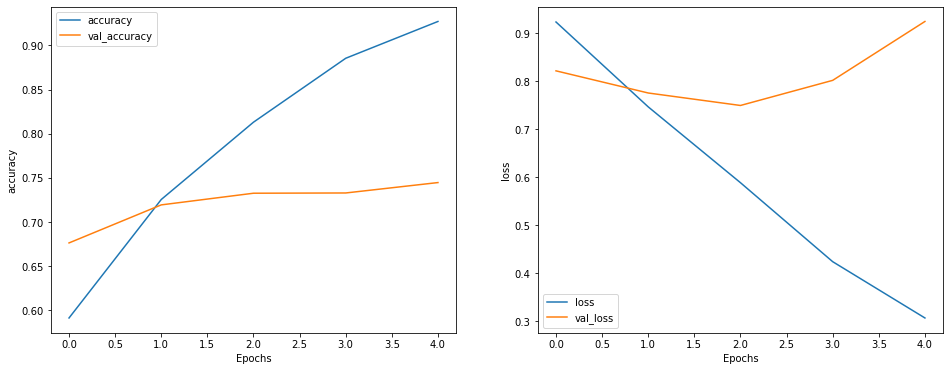

In [88]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [89]:
modelpath = f"model/rnn_{time}"
import_model = tf.keras.models.load_model(modelpath)
import_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_3 (TextVe (None, None)              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, None, 64)          3491840   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, None, 256)         197632    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 128)               164352    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)               

In [90]:
n = 5
inputs = []
with open(f"D:\\Work\\Data\\s24_2001_sentences_shuffled_slice.txt", 'r', encoding='utf-8') as f:
    lines = f.readlines()
    random.shuffle(lines)
    for line in lines:
        inputs.append(line.strip('\n'))
inputs = np.array(inputs[:n])
print(inputs[:n])

['Miten muuten ihmiset olisivat keksineet sanoja, kuten Zeus. '
 'No Bexiin on nyt rakennettu koko valoautomatiikka uusiksi, tosin ilmeisesti jo edellisellä omistajalla oli ollut vaikeuksia eikä autosta edes löytynyt mahdollisuutta saada pelkkiä parkkeja päälle :) '
 'Ikävänä yllätyksenä voin paljastaa että WTC:n tapahtumien takana olikin ihmiset ei jumala. '
 'siis tiedän että Iida hommaa kolmannen rotan ja olin huolestunut tiedoista joita Iida oli netistä saanut.ja tulos on tämä.'
 'Seurustelen 2onnellisesti" jo viidettä vuotta.. ']


In [91]:
def make_prediction(inps):
    predicted_scores = import_model.predict(np.array(inps))
    predicted_labels = tf.argmax(predicted_scores, axis=1)
    lab, pred = '', ''
    labs, preds = [], []
    for i, (inp, label) in enumerate(zip(inputs, predicted_labels)):
        pred = (', '.join(f'{q:.5f}' for q in predicted_scores[i]))
        lab = label.numpy()
        print(f"Sentence: {inp}")
        print(f"Predicted label: {lab}")
        print(f"Predicted probs: {pred}\n")
        labs.append(lab)
        preds.append(pred)
    return labs, preds

print(np.array(inputs), '\n\n', make_prediction(inputs))

Sentence: Miten muuten ihmiset olisivat keksineet sanoja, kuten Zeus. 
Predicted label: 1
Predicted probs: 0.03465, 0.82968, 0.13567

Sentence: No Bexiin on nyt rakennettu koko valoautomatiikka uusiksi, tosin ilmeisesti jo edellisellä omistajalla oli ollut vaikeuksia eikä autosta edes löytynyt mahdollisuutta saada pelkkiä parkkeja päälle :) 
Predicted label: 2
Predicted probs: 0.01273, 0.01014, 0.97713

Sentence: Ikävänä yllätyksenä voin paljastaa että WTC:n tapahtumien takana olikin ihmiset ei jumala. 
Predicted label: 1
Predicted probs: 0.00108, 0.88503, 0.11389

Sentence: siis tiedän että Iida hommaa kolmannen rotan ja olin huolestunut tiedoista joita Iida oli netistä saanut.ja tulos on tämä.
Predicted label: 1
Predicted probs: 0.01878, 0.56752, 0.41370

Sentence: Seurustelen 2onnellisesti" jo viidettä vuotta.. 
Predicted label: 1
Predicted probs: 0.31284, 0.58203, 0.10514

['Miten muuten ihmiset olisivat keksineet sanoja, kuten Zeus. '
 'No Bexiin on nyt rakennettu koko valoautomat